In [2]:
import pandas as pd

## Appliance Wise Validation

### Appliance Age and Power factor

In [3]:
# -------------------------------
# 1️⃣ Load similar usage CSV
# -------------------------------
similar_csv = '/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv'
similar_df = pd.read_csv(similar_csv)
similar_df = similar_df[['household_ID', 'cluster']]

# -------------------------------
# 2️⃣ Load autoencoder CSVs (clusters 0-6) and concatenate
# -------------------------------
ae_dfs = []
for i in range(6):
    path = f'/home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_2{i}.csv'
    df = pd.read_csv(path)
    df = df[['household_ID', 'cluster']]
    ae_dfs.append(df)

ae_df = pd.concat(ae_dfs, ignore_index=True)

In [4]:
ae_df

,household_ID,cluster
0,ID0060,0
1,ID0497,0
2,ID0835,0
3,ID0861,0
4,ID0914,0
...,...,...
243,ID3515,5
244,ID3558,5
245,ID3720,5
246,ID3776,5


In [5]:
appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')

/tmp/ipykernel_90523/2973607930.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')


In [6]:
appliance_age = appliance_age[['household_id','appliance_name','no_of_appliances','purchased_time1',
                              'purchased_time2','purchased_time3','purchased_time4']]

In [7]:
df = appliance_age.copy()

In [8]:
import pandas as pd
import numpy as np

# Define order of appliance age (older = larger number)
age_order = {
    'Within the last 1 year': 1,
    'Within the last 1-5 years': 2,
    'Wthin the last 1-5 years': 2,     # fix typo version
    'Within the last 5-10 years': 3,
    'Wthin the last 5-10 years': 3,    # fix typo version
    'More than 10 years ago': 4
}

# Columns to check
purchased_cols = ['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4']

# Convert categories to numeric according to hierarchy
df_numeric = df[purchased_cols].apply(lambda col: col.map(age_order))

# Find the oldest (maximum numeric value across columns)
df['appliance_age_code'] = df_numeric.max(axis=1, skipna=True)

# Map numeric code back to category name
reverse_age_order = {v: k for k, v in age_order.items()}
df['appliance_age'] = df['appliance_age_code'].map(reverse_age_order)

# Keep only the required columns
result = df[['household_id', 'appliance_name', 'appliance_age']].dropna(subset=['appliance_age']).reset_index(drop=True)

print(result.head())

  household_id   appliance_name              appliance_age
0       ID0430        Microwave     More than 10 years ago
1       ID0430      Rice cooker  Wthin the last 5-10 years
2       ID0430  Electric Kettle     More than 10 years ago
3       ID0528     Refrigerator     More than 10 years ago
4       ID0528      Rice cooker     Within the last 1 year


In [9]:
if not result.empty:
    def recode_age(age):
        """Simplify appliance age categories."""
        if age in ['More than 10 years ago', 'Unknown']:
            return 'Old'
        elif age in ['Within the last 1-5 years', 'Within the last 1 year']:
            return 'Recent'
        elif age in ['Within the last 5-10 years', 'Wthin the last 5-10 years']:
            return 'Middle'
        else:
            return 'Old'

    result['age_group'] = result['appliance_age'].apply(recode_age)
    print("\n✅ Appliance age groups recoded successfully.")
else:
    print("⚠️ No appliance data to recode.")


✅ Appliance age groups recoded successfully.


In [10]:
import pandas as pd

# Step 1: Define main appliances
main_appliances = [
    'Microwave',
    'Refrigerator',
    'Geyser / Hot water systems for bathrooms which operate from electricity',
    'Washing Machine',
    'Electric Oven',
    'Separate Freezer',
    'Air Conditioner',
    'Electric heater (to control room temperature)'
]

# Step 2: Filter only main appliances
filtered_df = result[result['appliance_name'].isin(main_appliances)].copy()

# Step 3: Check which households remain
if filtered_df.empty:
    print("⚠️ No main appliances found in the data.")
else:
    # Step 4: Count how many appliances fall under each age_group per household
    household_age_counts = (
        filtered_df.groupby(['household_id', 'age_group'])['appliance_name']
        .count()
        .reset_index(name='count')
    )

    # Step 5: Find the most common (mode) age group per household
    # If there are ties, this picks the first one alphabetically (you can change logic if needed)
    dominant_age = (
        household_age_counts.loc[
            household_age_counts.groupby('household_id')['count'].idxmax()
        ]
        .reset_index(drop=True)
    )

    # Step 6: Create the “most_...” column label
    dominant_age['dominant_category'] = 'most_' + dominant_age['age_group']

    # Step 7: Keep only household_id and dominant category
    household_dominant_age = dominant_age[['household_id', 'dominant_category']]

    print("\n✅ Dominant appliance age category computed successfully!\n")
    print(household_dominant_age.head())


✅ Dominant appliance age category computed successfully!

  household_id dominant_category
0       ID0001          most_Old
1       ID0002       most_Middle
2       ID0003       most_Middle
3       ID0005       most_Recent
4       ID0006       most_Middle


In [11]:
import pandas as pd
import os
import glob

# Directory path
dir_path = '/home/ranushi/test/Anomaly DetectionMethod/15min_interval'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(dir_path, '*.csv'))

# List to store dataframes
dfs = []

# Read each CSV file
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Calculate average powerfactor for each household
avg_powerfactor = combined_df.groupby('household_ID')['powerfactor'].mean().reset_index()
avg_powerfactor.columns = ['household_ID', 'average_powerfactor']

# Display the result
print(avg_powerfactor)

     household_ID  average_powerfactor
0          ID0013             0.754472
1          ID0018             0.205128
2          ID0041            -0.001664
3          ID0043             0.220554
4          ID0052             0.869455
...           ...                  ...
2933       ID5571             0.946570
2934       ID5572             0.121005
2935       ID5573             0.710816
2936       ID5574             0.553514
2937       ID5575             0.245074

[2938 rows x 2 columns]


In [12]:
age_powerfactor = pd.merge(household_dominant_age,avg_powerfactor, left_on='household_id', right_on='household_ID', how='inner')

In [13]:
filtered_data = age_powerfactor[
    (age_powerfactor['dominant_category'] == 'most_Old') & 
    (age_powerfactor['average_powerfactor'] < 0.75) &
    (age_powerfactor['average_powerfactor'].notna())
]

In [14]:
filtered_data

,household_id,dominant_category,household_ID,average_powerfactor
2,ID0041,most_Old,ID0041,-0.001664
5,ID0066,most_Old,ID0066,0.061352
6,ID0106,most_Old,ID0106,0.523001
14,ID0154,most_Old,ID0154,0.241896
26,ID0250,most_Old,ID0250,0.286587
...,...,...,...,...
820,ID3738,most_Old,ID3738,0.607396
825,ID3760,most_Old,ID3760,0.279393
831,ID3785,most_Old,ID3785,0.730197
832,ID3786,most_Old,ID3786,0.098233


In [15]:
import pandas as pd

# Load the comparison CSV
similar_usage_df = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv')

# Find intersection of household_IDs
common_households = set(filtered_data['household_id']).intersection(set(similar_usage_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 26
  household_ID
0       ID2383
1       ID1575
2       ID3282
3       ID1031
4       ID3560


In [16]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(filtered_data['household_ID'].unique())

In [17]:
# ======================================================
# 2️⃣ Load predicted anomalies
# ======================================================
similar_csv = '/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv'
predicted_anomalies_df = pd.read_csv(similar_csv)
predicted_anomalies = set(predicted_anomalies_df['household_ID'].unique())

In [18]:
# ======================================================
# 3️⃣ Load all households from 6-hour interval files
# ======================================================
folder_path = '/home/ranushi/test/Anomaly DetectionMethod/6hour_interval'
all_files = glob.glob(os.path.join(folder_path, '*.csv'))

all_households = set()
for file in all_files:
    df = pd.read_csv(file)
    if 'household_ID' in df.columns:
        all_households.update(df['household_ID'].unique())
    else:
        print(f"⚠️ Skipping {file}, no 'household_ID' column found.")

# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

/tmp/ipykernel_90523/4074882391.py:9: DtypeWarning: Columns (9,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_90523/4074882391.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_90523/4074882391.py:9: DtypeWarning: Columns (14,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_90523/4074882391.py:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [19]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    26                 75
Actual: Normal                      228               2621

Metrics Summary:
True Positives (TP): 26
False Negatives (FN): 75
False Positives (FP): 228
True Negatives (TN): 2621


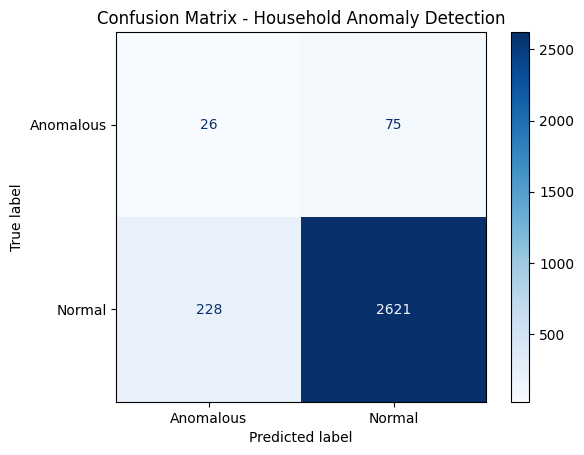

In [20]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [21]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.897
Precision: 0.102
Recall   : 0.257
F1 Score : 0.146

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.972     0.920     0.945      2849
   Anomalous      0.102     0.257     0.146       101

    accuracy                          0.897      2950
   macro avg      0.537     0.589     0.546      2950
weighted avg      0.942     0.897     0.918      2950



##  AC,Ref

In [20]:
appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')

/tmp/ipykernel_4116148/2973607930.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')


In [21]:
appliance_age = appliance_age[['household_id','appliance_name','no_of_appliances','purchased_time1',
                              'purchased_time2','purchased_time3','purchased_time4']]

In [23]:
df = appliance_age.copy()

In [24]:
import pandas as pd
import numpy as np

# Define order of appliance age (older = larger number)
age_order = {
    'Within the last 1 year': 1,
    'Within the last 1-5 years': 2,
    'Wthin the last 1-5 years': 2,     # fix typo version
    'Within the last 5-10 years': 3,
    'Wthin the last 5-10 years': 3,    # fix typo version
    'More than 10 years ago': 4
}

# Columns to check
purchased_cols = ['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4']

# Convert categories to numeric according to hierarchy
df_numeric = df[purchased_cols].apply(lambda col: col.map(age_order))

# Find the oldest (maximum numeric value across columns)
df['appliance_age_code'] = df_numeric.max(axis=1, skipna=True)

# Map numeric code back to category name
reverse_age_order = {v: k for k, v in age_order.items()}
df['appliance_age'] = df['appliance_age_code'].map(reverse_age_order)

# Keep only the required columns
result = df[['household_id', 'appliance_name', 'appliance_age']].dropna(subset=['appliance_age']).reset_index(drop=True)

print(result.head())

  household_id   appliance_name              appliance_age
0       ID0430        Microwave     More than 10 years ago
1       ID0430      Rice cooker  Wthin the last 5-10 years
2       ID0430  Electric Kettle     More than 10 years ago
3       ID0528     Refrigerator     More than 10 years ago
4       ID0528      Rice cooker     Within the last 1 year


#### AC, REF More than 5 years

In [61]:
# Define target appliances
target_appliances = ['Air Conditioner', 'Refrigerator']

# Define old or unknown age categories
old_or_unknown = [
    'Within the last 5-10 years',
    'Wthin the last 5-10 years',
    'More than 10 years ago'
]

# Filter rows for those appliances and ages (or NaN)
filtered1 = result[
    (result['appliance_name'].isin(target_appliances)) &
    (result['appliance_age'].isin(old_or_unknown) | result['appliance_age'].isna())
]

# Get unique household IDs that meet the condition
households_to_flag1 = filtered1['household_id'].unique()



In [62]:
len(households_to_flag1)

1742

In [63]:
households_to_flag1 = pd.DataFrame(households_to_flag1, columns=['household_id'])
households_to_flag1

,household_id
0,ID0528
1,ID2328
2,ID1146
3,ID2755
4,ID2663
...,...
1737,ID2496
1738,ID0320
1739,ID0373
1740,ID0160


In [64]:
### for socio economic class
import pandas as pd

# Load the comparison CSV
similar_usage_df = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv')

# Find intersection of household_IDs
common_households = set(households_to_flag1['household_id']).intersection(set(similar_usage_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 119
  household_ID
0       ID2911
1       ID1424
2       ID1778
3       ID0773
4       ID0796


In [65]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_to_flag1['household_id'].unique())

In [66]:
# ======================================================
# 2️⃣ Load predicted anomalies
# ======================================================
similar_csv = '/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv'
predicted_anomalies_df = pd.read_csv(similar_csv)
predicted_anomalies = set(predicted_anomalies_df['household_ID'].unique())

In [37]:
# ======================================================
# 3️⃣ Load all households from 6-hour interval files
# ======================================================
folder_path = '/home/ranushi/test/Anomaly DetectionMethod/6hour_interval'
all_files = glob.glob(os.path.join(folder_path, '*.csv'))

all_households = set()
for file in all_files:
    df = pd.read_csv(file)
    if 'household_ID' in df.columns:
        all_households.update(df['household_ID'].unique())
    else:
        print(f"⚠️ Skipping {file}, no 'household_ID' column found.")

# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

/tmp/ipykernel_4116148/4074882391.py:9: DtypeWarning: Columns (9,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4116148/4074882391.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4116148/4074882391.py:9: DtypeWarning: Columns (14,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4116148/4074882391.py:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [67]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                   119                519
Actual: Normal                      135               2177

Metrics Summary:
True Positives (TP): 119
False Negatives (FN): 519
False Positives (FP): 135
True Negatives (TN): 2177


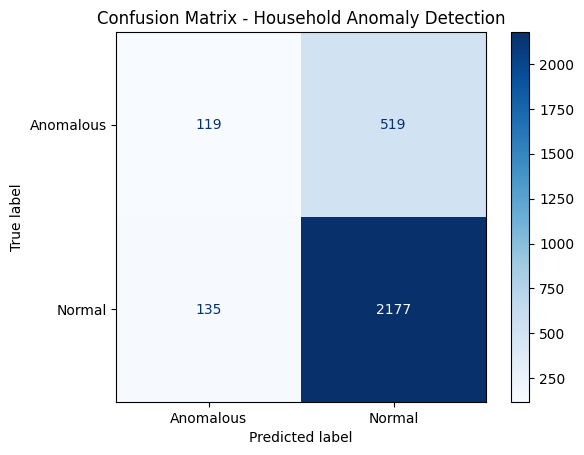

In [68]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [69]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.778
Precision: 0.469
Recall   : 0.187
F1 Score : 0.267

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.807     0.942     0.869      2312
   Anomalous      0.469     0.187     0.267       638

    accuracy                          0.778      2950
   macro avg      0.638     0.564     0.568      2950
weighted avg      0.734     0.778     0.739      2950



#### AC, REF more than 10 years

In [50]:
result

,household_id,appliance_name,appliance_age
0,ID0430,Microwave,More than 10 years ago
1,ID0430,Rice cooker,Wthin the last 5-10 years
2,ID0430,Electric Kettle,More than 10 years ago
3,ID0528,Refrigerator,More than 10 years ago
4,ID0528,Rice cooker,Within the last 1 year
...,...,...,...
11300,ID1667,TV,Wthin the last 5-10 years
11301,ID1667,Computers,Wthin the last 5-10 years
11302,ID1667,Laptops,Wthin the last 5-10 years
11303,ID1667,Electric Water pump,More than 10 years ago


In [70]:
# Define target appliances
target_appliances = ['Air Conditioner', 'Refrigerator']

# Define old or unknown age categories
old_or_unknown = [
    'More than 10 years ago'
]

# Filter rows for those appliances and ages (or NaN)
filtered2 = result[
    (result['appliance_name'].isin(target_appliances)) &
    (result['appliance_age'].isin(old_or_unknown) | result['appliance_age'].isna())
]

# Get unique household IDs that meet the condition
households_to_flag2 = filtered2['household_id'].unique()


In [71]:
len(households_to_flag2)

896

In [72]:
households_to_flag2 = pd.DataFrame(households_to_flag2, columns=['household_id'])
households_to_flag2

,household_id
0,ID0528
1,ID1146
2,ID2663
3,ID0016
4,ID0055
...,...
891,ID3731
892,ID2272
893,ID1349
894,ID0320


In [73]:
### for socio economic class
import pandas as pd

# Load the comparison CSV
similar_usage_df = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv')

# Find intersection of household_IDs
common_households = set(households_to_flag2['household_id']).intersection(set(similar_usage_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 64
  household_ID
0       ID2273
1       ID2911
2       ID1424
3       ID0551
4       ID2505


In [74]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_to_flag2['household_id'].unique())

In [78]:
len(true_anomalies)

896

In [75]:
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

In [76]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    64                262
Actual: Normal                      190               2434

Metrics Summary:
True Positives (TP): 64
False Negatives (FN): 262
False Positives (FP): 190
True Negatives (TN): 2434


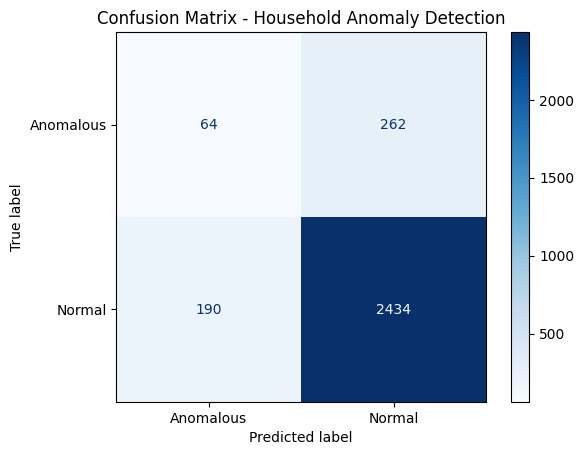

In [79]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [80]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.847
Precision: 0.252
Recall   : 0.196
F1 Score : 0.221

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.903     0.928     0.915      2624
   Anomalous      0.252     0.196     0.221       326

    accuracy                          0.847      2950
   macro avg      0.577     0.562     0.568      2950
weighted avg      0.831     0.847     0.838      2950



In [81]:
result

,household_id,appliance_name,appliance_age
0,ID0430,Microwave,More than 10 years ago
1,ID0430,Rice cooker,Wthin the last 5-10 years
2,ID0430,Electric Kettle,More than 10 years ago
3,ID0528,Refrigerator,More than 10 years ago
4,ID0528,Rice cooker,Within the last 1 year
...,...,...,...
11300,ID1667,TV,Wthin the last 5-10 years
11301,ID1667,Computers,Wthin the last 5-10 years
11302,ID1667,Laptops,Wthin the last 5-10 years
11303,ID1667,Electric Water pump,More than 10 years ago


In [83]:
import pandas as pd

# assuming your dataframe is called df

# clean up common spelling variations (optional but useful)
result['appliance_age'] = result['appliance_age'].replace({
    'Wthin the last 5-10 years': 'Within the last 5-10 years'
})

# condition for Air Conditioners
cond_aircon = (
    (result['appliance_name'].str.lower().str.strip() == 'air conditioner') &
    (result['appliance_age'].isin([
        'Within the last 5-10 years',
        'More than 10 years ago'
    ]))
)

# condition for Refrigerator
cond_fridge = (
    (result['appliance_name'].str.lower().str.strip() == 'refrigerator') &
    (result['appliance_age'] == 'More than 10 years ago')
)

# combine both conditions
filtered_df3 = result[cond_aircon | cond_fridge]

# if you want only unique households that meet the criteria:
households_filtered3 = filtered_df3['household_id'].unique()

# # optionally filter original df to show all appliances of those households
# households_df3 = result[result['household_id'].isin(households_filtered3)]



In [85]:
len(households_filtered3)

899

In [87]:
households_filtered3 = pd.DataFrame(households_filtered3, columns=['household_id'])

In [88]:
### for socio economic class
import pandas as pd

# Load the comparison CSV
similar_usage_df = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv')

# Find intersection of household_IDs
common_households = set(households_filtered3['household_id']).intersection(set(similar_usage_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 64
  household_ID
0       ID2273
1       ID2911
2       ID1424
3       ID0551
4       ID2505


In [89]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_filtered3['household_id'].unique())

In [90]:
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

In [91]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    64                263
Actual: Normal                      190               2433

Metrics Summary:
True Positives (TP): 64
False Negatives (FN): 263
False Positives (FP): 190
True Negatives (TN): 2433


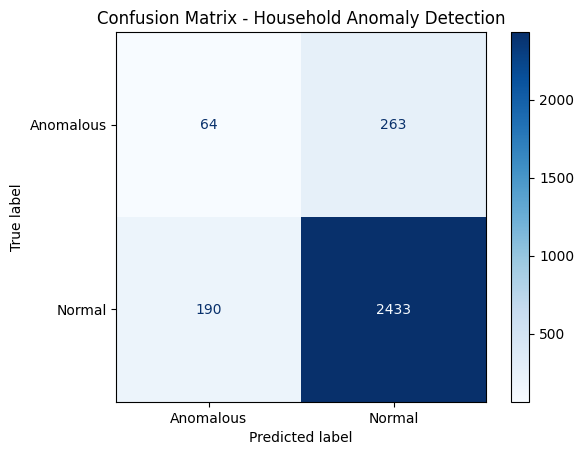

In [92]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [93]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.846
Precision: 0.252
Recall   : 0.196
F1 Score : 0.220

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.902     0.928     0.915      2623
   Anomalous      0.252     0.196     0.220       327

    accuracy                          0.846      2950
   macro avg      0.577     0.562     0.568      2950
weighted avg      0.830     0.846     0.838      2950



#### ac>10,ref>5

In [94]:
import pandas as pd

# assuming your dataframe is called df

# clean up common spelling variations (optional but useful)
result['appliance_age'] = result['appliance_age'].replace({
    'Wthin the last 5-10 years': 'Within the last 5-10 years'
})

# condition for Air Conditioners
cond_aircon = (
    (result['appliance_name'].str.lower().str.strip() == 'air conditioner') &
    (result['appliance_age'].isin([
        'More than 10 years ago'
    ]))
)

# condition for Refrigerator
cond_fridge = (
    (result['appliance_name'].str.lower().str.strip() == 'refrigerator') &
    (result['appliance_age'].isin(['More than 10 years ago','Within the last 5-10 years']))
)

# combine both conditions
filtered_df4 = result[cond_aircon | cond_fridge]

# if you want only unique households that meet the criteria:
households_filtered4 = filtered_df4['household_id'].unique()

In [96]:
households_filtered4 = pd.DataFrame(households_filtered4, columns=['household_id'])

In [97]:
### for socio economic class
import pandas as pd

# Load the comparison CSV
similar_usage_df = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv')

# Find intersection of household_IDs
common_households = set(households_filtered4['household_id']).intersection(set(similar_usage_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 119
  household_ID
0       ID2911
1       ID1424
2       ID1778
3       ID0773
4       ID0796


In [98]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_filtered4['household_id'].unique())

In [99]:
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

In [100]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                   119                518
Actual: Normal                      135               2178

Metrics Summary:
True Positives (TP): 119
False Negatives (FN): 518
False Positives (FP): 135
True Negatives (TN): 2178


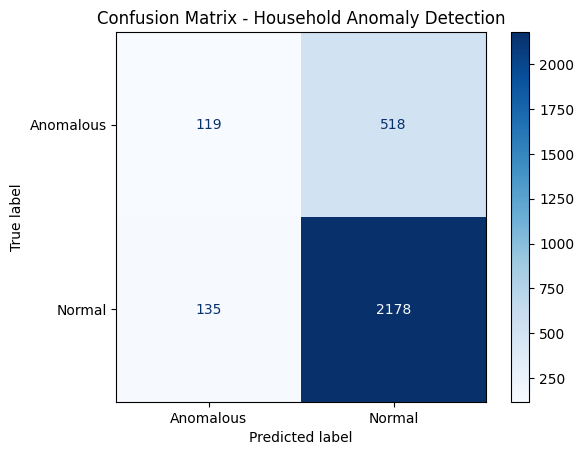

In [101]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [102]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.779
Precision: 0.469
Recall   : 0.187
F1 Score : 0.267

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.808     0.942     0.870      2313
   Anomalous      0.469     0.187     0.267       637

    accuracy                          0.779      2950
   macro avg      0.638     0.564     0.568      2950
weighted avg      0.735     0.779     0.740      2950



In [103]:
survey_data = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_household_information_and_history.csv')

In [105]:
survey_data.columns

Index(['household_ID', 'no_of_electricity_meters',
       'electricity_provider_csc_area', 'own_the_house_or_living_on_rent',
       'occupy_renters_boarders',
       'awareness_of_electricity_consumption_of_renters',
       'built_year_of_the_house', 'type_of_house', 'floor_which_house_located',
       'no_of_storeys', 'floor_area', 'no_of_household_members',
       'charging_method_of_renters_for_electricity',
       'charged_method_for_rent_for_electricity',
       'is_there_business_carried_out_in_the_household', 'type_of_business',
       'whom_or_how_the_house_was_designed',
       'availability_of_certificate_of_compliance',
       'main_material_used_for_walls_of_the_house',
       'main_material_used_for_roof_of_the_house',
       'any_constructions_or_renovations_in_the_household',
       'highest_level_of_education_of_the_chief_wage_earner',
       'occupation_of_the_chief_wage_earner', 'socio_economic_class',
       'total_monthly_expenditure_of_last_month', 'type_of_electr

In [ ]:
survey_data = survey_data[['household_ID', 'built_year_of_the_house']]


In [108]:
survey_data['built_year_of_the_house'].value_counts()

built_year_of_the_house
2000-2009                918
2010-2019                758
Before 1980              740
1990-1999                615
1980-1989                482
Don't know               325
In 2020 or After 2020    225
Name: count, dtype: int64

In [109]:
survey_data

,household_ID,built_year_of_the_house
0,ID0001,2000-2009
1,ID0002,Before 1980
2,ID0003,1980-1989
3,ID0004,2010-2019
4,ID0005,2010-2019
...,...,...
4058,ID4059,In 2020 or After 2020
4059,ID4060,Before 1980
4060,ID4061,2000-2009
4061,ID4062,1980-1989


In [114]:
# assuming your dataframe is called survey_data

target_years = ['Before 1980', '1990-1999', '1980-1989', "Don't know"]

filtered_survey = survey_data[survey_data['built_year_of_the_house'].isin(target_years)]

# if you just want the IDs of those households:
households_filtered5 = filtered_survey['household_ID'].unique()


In [115]:
len(households_filtered5)

2162

In [116]:
households_filtered5 = pd.DataFrame(households_filtered5, columns=['household_ID'])
households_filtered5

,household_ID
0,ID0002
1,ID0003
2,ID0010
3,ID0013
4,ID0019
...,...
2157,ID4054
2158,ID4057
2159,ID4058
2160,ID4060


In [118]:
### for socio economic class
import pandas as pd

# Load the comparison CSV
similar_usage_df = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv')

# Find intersection of household_IDs
common_households = set(households_filtered5['household_ID']).intersection(set(similar_usage_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 123
  household_ID
0       ID1424
1       ID1778
2       ID0773
3       ID0796
4       ID1751


In [120]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_filtered5['household_ID'].unique())

In [121]:
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

In [122]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                   123                650
Actual: Normal                      131               2046

Metrics Summary:
True Positives (TP): 123
False Negatives (FN): 650
False Positives (FP): 131
True Negatives (TN): 2046


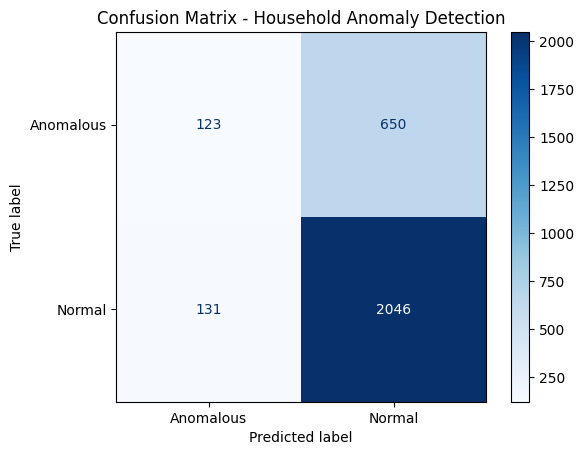

In [123]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [124]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.735
Precision: 0.484
Recall   : 0.159
F1 Score : 0.240

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.759     0.940     0.840      2177
   Anomalous      0.484     0.159     0.240       773

    accuracy                          0.735      2950
   macro avg      0.622     0.549     0.540      2950
weighted avg      0.687     0.735     0.682      2950

